Step 1: Importing Dataset from Kaggle (2.6Gb)

In [5]:
!pip install kaggle
!pip install opendatasets


import opendatasets as od

od.download("https://www.kaggle.com/datasets/plhalvorsen/kvasir-v2-a-gastrointestinal-tract-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: srikrishnakireeti
Your Kaggle Key: ··········


100%|██████████| 2.32G/2.32G [00:34<00:00, 72.2MB/s]


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50V2, EfficientNetV2L, MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing

from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
import numpy as np
import pandas as pd
import shutil

In [6]:
dataset_path = "/content/kvasir-v2-a-gastrointestinal-tract-dataset"

labels = os.listdir(dataset_path)
data = []

for label in labels:
    length = len(os.listdir(os.path.join(dataset_path, label, label)))
    data.append([label, length])

print(tabulate(data, headers=['Type', 'Number of Files']))

Type                      Number of Files
----------------------  -----------------
dyed-lifted-polyps                   1000
esophagitis                          1000
ulcerative-colitis                   1000
normal-pylorus                       1000
polyps                               1000
normal-cecum                         1000
dyed-resection-margins               1000
normal-z-line                        1000


In [14]:
rescale = preprocessing.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomContrast(factor=0.2),
    preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
    preprocessing.RandomRotation(factor=0.2),
    preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomFlip("vertical")
])

train = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=(224, 224),
    batch_size=64
).map(lambda x, y: (rescale(data_augmentation(x)), y))  # Apply rescaling and data augmentation to the images

val = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=(224, 224),
    batch_size=64
).map(lambda x, y: (rescale(x), y))  # Only apply rescaling to the validation images


Found 8000 files belonging to 8 classes.
Using 4800 files for training.
Found 8000 files belonging to 8 classes.
Using 3200 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(val)
test = val.take(val_batches // 2)
val = val.skip(val_batches // 2)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.prefetch(buffer_size=AUTOTUNE)
val_ds = val.prefetch(buffer_size=AUTOTUNE)
test_ds = test.prefetch(buffer_size=AUTOTUNE)

# **1. RESNET50**

In [7]:
base_model = ResNet50V2(weights='imagenet' , include_top=False, input_shape=(224, 224, 3), classifier_activation="softmax")

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23581192 (89.96 MB)
Trainable params: 23535752 (89.78 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.8365 - accuracy: 0.6842
Epoch 1: val_loss improved from inf to 8.80097, saving model to best_ResNet50_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 207s 2s/step - loss: 0.8365 - accuracy: 0.6842 - val_loss: 8.8010 - val_accuracy: 0.2375
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.7996
Epoch 2: val_loss improved from 8.80097 to 1.59227, saving model to best_ResNet50_model.h5
75/75 [==============================] - 161s 2s/step - loss: 0.5228 - accuracy: 0.7996 - val_loss: 1.5923 - val_accuracy: 0.6687
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.8131
Epoch 3: val_loss improved from 1.59227 to 1.18308, saving model to best_ResNet50_model.h5
75/75 [==============================] - 158s 2s/step - loss: 0.4634 - accuracy: 0.8131 - val_loss: 1.1831 - val_accuracy: 0.6712
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.8313
Epoch 4: val_loss improved from 1.18308 to 0.78635, saving model to best_ResNet50_model.h5
75/75 [==============================] - 160s 2s/step -

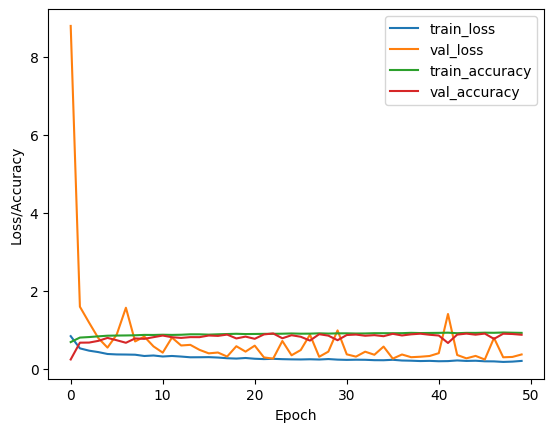

In [8]:
checkpoint = ModelCheckpoint('best_ResNet50_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[checkpoint],
    steps_per_epoch=tf.data.experimental.cardinality(train_ds).numpy(),
    validation_steps=tf.data.experimental.cardinality(val_ds).numpy()
)

# Display training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [9]:
model.load_weights('/content/best_ResNet50_model.h5')

test_loss, test_accuracy = model.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

25/25 [==============================] - 16s 481ms/step - loss: 0.2849 - accuracy: 0.8944
Test loss: 0.28488653898239136
Test accuracy: 0.8943750262260437


**CONFUSION MATRIX**

2/2 [==============================] - 0s 88ms/step
[[155  34   0   1   0   0   0   0]
 [  6 201   0   0   0   0   0   0]
 [  0   0 141   0   0  81   0   0]
 [  0   0   0 200   0   0   1   0]
 [  0   0   0   0 177   1   2   0]
 [  0   0  17   0   2 175   0   0]
 [  1   1   0  11   2   0 193   3]
 [  1   0   0  13   0   0   8 173]]


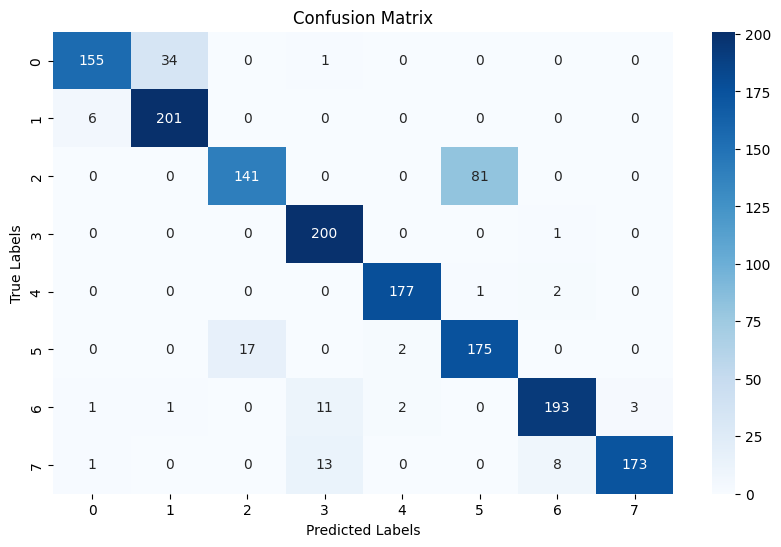

In [15]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

# Iterate over the test dataset to get true labels and predictions
for x, y in test_ds:
    y_true.extend(y.numpy().argmax(axis=1))  # Assuming y is one-hot encoded
    y_pred.extend(model.predict(x).argmax(axis=1))

cm = confusion_matrix(y_true, y_pred)

print(cm)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from sklearn.metrics import f1_score, recall_score
# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

print("F1 score:", f1)
print("Recall:", recall)

F1 score: 0.8833478451875911
Recall: 0.884375
